# Projection on vertical modes

This notebook shows how to use the module and class vmodes for computing vertical modes and projecting/reconstructing dynamical fields in a CROCO Run.

The procedure is as follows:
* Load simulation using postp.Run
* compute mean stratification
* compute vertical modes using vmodes.Vmodes
* project, reconstruct, ...
* store vertical modes and projections

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt

from numpy import pi
import xarray as xr
from xgcm import Grid

import crocosi.postp as pp
import crocosi.gridop as gop
import crocosi.vmodes as vmd

# Load simulation and compute mean stratification
loading simulation from netcdf files using postp Run class

In [5]:
### Load simulation

root_path = '/home/c11-data/Test_aponte/jetn/old/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'
    
it = 1 # time index (working with one time index for this example)

r = pp.Run(root_path+run, prefix='', outputs=['grid','his'], verbose=False)
ds = r['his'].isel(time=it)

## First example: single horizontal point. 
N2 is the average over a portion of the domain

In [6]:
### select sub-dataset for defining mean stratif
nx, ny = 100, 100
sds = ds.isel(x_rho=range(nx), y_rho=range(ny))

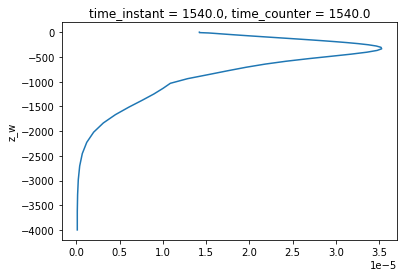

In [7]:
### Compute mean quantities:

ssh_mean = sds.ssh_a.mean()
h_mean = r['grid'].h.isel(x_rho=range(nx), y_rho=range(ny)).mean()

zr_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='r', hgrid='r')
zw_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='w', hgrid='r')

z_rho = r.get_z(zeta=sds.ssh_a, vgrid="r", hgrid="r")
T_mean = gop.interp2z(zr_mean, z_rho, sds.T_a).mean(["x_rho","y_rho"]) # interpolate on mean grid
N2 = r.get_N2(T_mean, zr_mean).chunk({"s_w":-1}) # compute stratif
N2 = N2.assign_coords(z_w=zw_mean).persist()

N2.plot(y="z_w")

### Compute vertical modes

Vmode object with dimensions ('mode', 's_rho', 's_w')
  Number of modes = 10
  N2, min/max = 1.2e-07, 3.5e-05
  Options / parameters: g=9.81, free_surf=True, eig_sigma=1.0e-01

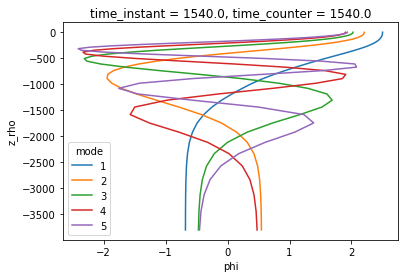

In [8]:
### compute modes
nmodes = 10

### we need to define a xgcm grid
gridcoord = {key:val.coords for key,val in r.xgrid.axes.items() if key not in ["xi", "eta"]}
xgrid = Grid(sds, coords=gridcoord, periodic=False)

vmodes = vmd.Vmodes(xgrid, zr_mean, zw_mean, N2, nmodes, persist=False) 

### plot and show results
vmodes['phi'].sel(mode=slice(1,5)).plot.line(y="z_rho", hue='mode') 

### display vmodes content
vmodes

### Project and reconstruct at a single point (pressure and vertical velocity)

Text(0.5, 1.0, 'w_cos')

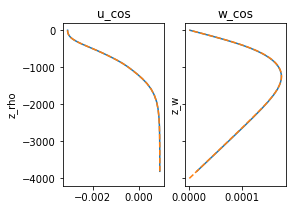

In [9]:
jy, ix = 10, 20 # isel in sds
subds = sds.isel(y_rho=jy, x_rho=ix, x_u=ix) # x_u=ix is an approximate shortcut...

h0 = r.ds['grid'].h.sel(x_rho=subds.x_rho, y_rho=subds.y_rho)
z_r = r.get_z(zeta=subds.ssh_a, h=h0, hgrid="r", vgrid="r")

### project
un = vmodes.project(subds.u_t_cos, "p", align=True, z=z_r)
wn = vmodes.project_w(subds.w_t_cos, align=True, z=z_r)
### and reconstruct
u_rec = vmodes.reconstruct(un, "u")
w_rec = vmodes.reconstruct(wn, "w")

### plot result
fig, axs = plt.subplots(1, 2, figsize=(4,3), sharey=True)
subds.u_t_cos.assign_coords(z_rho=z_r).plot(y="z_rho", ax=axs[0], label="true")
u_rec.plot(y="z_rho", ax=axs[0], label="reco", linestyle="--")
axs[0].set_title('u_cos')

subds.w_t_cos.assign_coords(z_rho=z_r).plot(y="z_rho", ax=axs[1], label="true")
vmodes.reconstruct_w(wn).plot(y="z_w", ax=axs[1], label="reco", linestyle="--")
axs[1].set_title('w_cos')

#### minor disgression: storing and loading vertical modes and projections

In [9]:
# store
ds_proj = xr.merge([un.rename('u'), wn.rename('w')])
r.store_vmodes('vmodes_1d', vmodes, projections=ds_proj, mode='w')

Store vertical modes in /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/diagnostics/vmodes_1d.zarr
Store projections in /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/diagnostics/vmodes_1d_projections.zarr


<xarray.Dataset>
Dimensions:  (mode: 11)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    u        (mode) float64 dask.array<chunksize=(11,), meta=np.ndarray>
    w        (mode) float64 dask.array<chunksize=(11,), meta=np.ndarray>
Attributes:
    f:             8.043722482398152e-05
    s_w:           0.0
    time_counter:  1540.0
    time_instant:  1540.0
    x_rho:         78000.0
    x_u:           80000.0
    x_v:           78000.0
    y_rho:         38000.0
    y_u:           38000.0

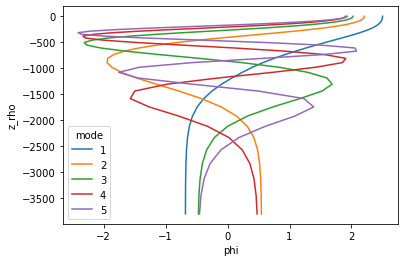

In [11]:
vmodes_loaded, ds_proj_loaded = r.load_vmodes('vmodes_1d', persist=True)
vmodes_loaded['phi'].sel(mode=slice(1,5)).plot.line(y="z_rho", hue='mode')
ds_proj_loaded

## 2nd example: vertical modes are $y$-dependent

Mean stratif is an average along $x$

In [10]:
### select portion of dataset
sliy = slice(100, -100, 2)
sds = ds.isel(y_rho=sliy)

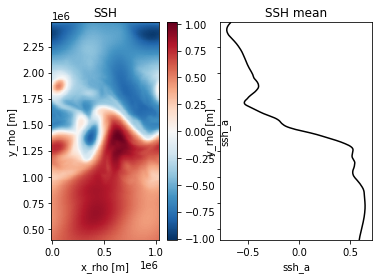

In [11]:
### compute and plot mean ssh (and vertical levels)
ssh_mean = sds.ssh_a.mean(dim='x_rho')
h_mean = r['grid'].h.isel(y_rho=sliy).mean(dim="x_rho")
    
fig, axs = plt.subplots(1, 2, sharey=True)
sds.ssh_a.plot(ax=axs[0])
ssh_mean.plot(ax=axs[1], y="y_rho", color="k")
axs[0].set_aspect('equal')
axs[0].set_title('SSH')
axs[1].set_title('SSH mean')

# and compute mean vertical grids
zr_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='r', hgrid='r').persist()
zw_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='w', hgrid='r').persist()

Text(0.5, 1.0, 'mean N2')

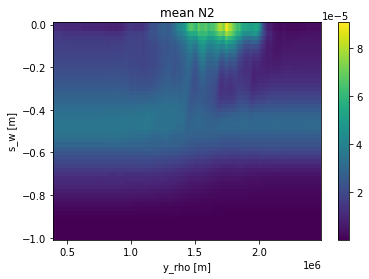

In [12]:
# compute mean stratification
z_rho = r.get_z(zeta=sds.ssh_a, vgrid="r", hgrid="r")
T_mean = gop.interp2z(zr_mean, z_rho, sds.T_a).mean("x_rho") # interpolate on mean grid
N2 = r.get_N2(T_mean, zr_mean).chunk({"s_w":-1}) # compute stratif
N2 = N2.assign_coords(z_w=zw_mean).persist()

### plot result    
N2.plot(y="s_w")
plt.title("mean N2")

### compute vertical modes

Vmode object with dimensions ('mode', 's_rho', 's_w', 'y_rho')
  Number of modes = 8
  N2, min/max = 1.0e-07, 9.1e-05
  Options / parameters: g=9.81, free_surf=True, eig_sigma=1.0e-01

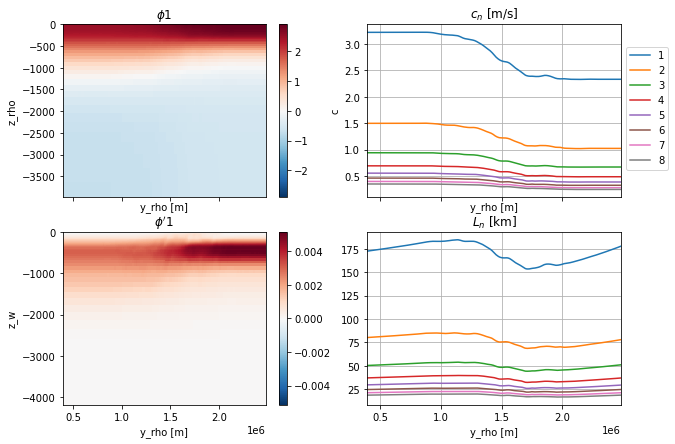

In [37]:
### compute modes
nmodes = 8

# create xgcm grid
gridcoord = {key:val.coords for key,val in r.xgrid.axes.items() if key not in "xi"}
xgrid = Grid(sds, coords=gridcoord, periodic=['eta'])
    
vmodes = vmd.Vmodes(xgrid, zr_mean, zw_mean, N2, nmodes, persist=True) # working version
omega = 2.*pi/(12.*3600)
lwave = 2*pi*vmodes["c"] / (omega**2 - vmodes["f"]**2)**.5 *1e-3 # horizontal lengthscale [km]

# plot result (for one mode)
imod = 1
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(10,7))

vmodes.ds.phi.sel(mode=imod).plot(x="y_rho", y="z_rho", ax=axs[0,0], cbar_kwargs={"label":""})
axs[0,0].set_title(r"$\phi $"+str(imod))

vmodes.ds.dphidz.sel(mode=imod).plot(x="y_rho", y="z_w", ax=axs[1,0], cbar_kwargs={"label":""})
axs[1,0].set_title(r"$\phi' $"+str(imod))

hpl = vmodes.ds.c.isel(mode=slice(1,None)).plot.line(x="y_rho", ax=axs[0,1], add_legend=False)
axs[0,1].grid(True)
axs[0,1].set_title(r"$c_n$ [m/s]")
axs[0, 1].legend(hpl, vmodes['mode'][1:].values, bbox_to_anchor=(1,.9))

lwave.isel(mode=slice(1,None)).plot.line(x="y_rho", ax=axs[1,1], add_legend=False)
axs[1,1].grid(True)
axs[1,1].set_title(r"$L_n$ [km]")

# show result
vmodes

### Project and reconstruct at a single point (pressure and vertical velocity)

/home1/datahome/aponte/croco/crocosi/gridop.py:536: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  vout = vout.transpose(*output_dims)
/home1/datahome/aponte/croco/crocosi/gridop.py:536: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  vout = vout.transpose(*output_dims)


Text(0.5, 1.0, 'w_cos')

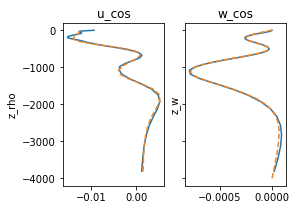

In [16]:
jy, ix = 100, 0 # isel in sds
subds = sds.isel(y_rho=[jy], x_rho=ix, x_u=ix) # x_u=ix is an approximate shortcut...

h0 = r.ds['grid'].h.isel(x_rho=ix).sel(y_rho=subds.y_rho)
z_r = r.get_z(zeta=subds.ssh_a, h=h0, hgrid="r", vgrid="r")

### project
un = vmodes.project(subds.u_t_cos, "p", align=True, z=z_r)
wn = vmodes.project_w(subds.w_t_cos, align=True, z=z_r)
### and reconstruct
u_rec = vmodes.reconstruct(un, "u")
w_rec = vmodes.reconstruct(wn, "w")

### plot result
fig, axs = plt.subplots(1, 2, figsize=(4,3), sharey=True)
subds.u_t_cos.assign_coords(z_rho=z_r).plot(y="z_rho", ax=axs[0], label="true")
u_rec.plot(y="z_rho", ax=axs[0], label="reco", linestyle="--")
axs[0].set_title('u_cos')

subds.w_t_cos.assign_coords(z_rho=z_r).plot(y="z_rho", ax=axs[1], label="true")
vmodes.reconstruct_w(wn).plot(y="z_w", ax=axs[1], label="reco", linestyle="--")
axs[1].set_title('w_cos')

### Project horizontal velocity (2D modal amplitude)

/home1/datahome/aponte/croco/crocosi/gridop.py:536: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  vout = vout.transpose(*output_dims)


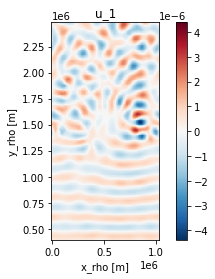

In [17]:
### project on the full domain and plot modal amplitude

imod = 1

un = vmodes.project(sds.w_t_cos, "w", align=True, z=z_rho, sel={"mode":imod})

hdl = un.plot()
hdl.axes.set_title('u_{}'.format(imod))
hdl.axes.set_aspect('equal')